# Modelos Predictivos: Indicadores Digitales → Salud Mental

Este notebook implementa **modelos de Machine Learning** para predecir puntuaciones de salud mental (UCLA, DASS-21) a partir de indicadores comportamentales digitales.

##  Objetivos

1. **Validar capacidad predictiva**: ¿Los indicadores digitales realmente predicen salud mental?
2. **Identificar indicadores clave**: ¿Qué features son más importantes?
3. **Cuantificar precisión**: Métricas estándar (R², MAE, RMSE)
4. **Comparar Real vs Predicho**: Visualizaciones de ajuste del modelo
5. **Interpretabilidad**: SHAP values para explicar predicciones

##  Metodología

- **Algoritmo**: Random Forest (robusto con muestras pequeñas)
- **Validación**: Leave-One-Out Cross-Validation (ideal para n<30)
- **Variables objetivo**: UCLA Total, DASS Depresión, DASS Ansiedad, DASS Estrés
- **Features**: 14 indicadores digitales (emocionales, lingüísticos, actividad)

In [36]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Machine Learning
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# Para interpretabilidad (opcional, si está instalado)
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print(" SHAP no disponible. Instalar con: pip install shap")

import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline

# Semilla para reproducibilidad
np.random.seed(42)

print("✓ Librerías importadas")
print(f"✓ SHAP disponible: {SHAP_AVAILABLE}")

✓ Librerías importadas
✓ SHAP disponible: True


## 1. Cargar y Preparar Datos

In [37]:
# Cargar dataset consolidado
df = pd.read_csv('../data/features/final/dataset_consolidado.csv')

print(f"Dataset cargado: {len(df)} participantes")
print(f"Variables: {df.shape[1]}\n")

# Crear carpeta de salida
output_path = Path('../data/results')
output_path.mkdir(exist_ok=True, parents=True)

df.head()

Dataset cargado: 18 participantes
Variables: 43



,id_participante,num_publicaciones,promedio_palabras,promedio_caracteres,promedio_longitud_palabra,promedio_palabras_unicas,promedio_riqueza_lexica,promedio_exclamaciones,promedio_preguntas,promedio_pronombres_1era_sing,promedio_pronombres_1era_plur,promedio_pronombres_2da,promedio_pronombres_3era,promedio_absolutistas,promedio_negativas,promedio_causales,promedio_tentativas,total_emojis,promedio_emojis_por_palabra,promedio_score_positivo,promedio_score_negativo,promedio_score_neutral,promedio_alegria,promedio_tristeza,promedio_enojo,promedio_miedo,promedio_sorpresa,promedio_disgusto,ratio_pos_neg,timestamp,edad,genero,ano_academico,actividades_extra,miembro_wa,ucla_total,ucla_categoria,dass_depresion,dass_ansiedad,dass_estres,dass_depresion_cat,dass_ansiedad_cat,dass_estres_cat
0,EST001,1515,11.672607,62.170297,4.397393,10.619142,0.960832,0.006601,0.145875,1.619723,0.530792,0.774330,5.878191,1.066561,1.709611,0.376218,0.212944,274,0.017742,0.138382,0.277447,0.584172,0.051905,0.029036,0.031317,0.006169,0.023445,0.007196,0.496979,2025-11-07 23:43:26.253,26,Masculino,5,Sí,Sí,54,Alta soledad,28,10,28,Extremadamente severa,Moderada,Severo
1,EST002,589,9.509338,50.213922,4.310645,8.887946,0.976294,0.000000,0.110357,2.251290,0.545535,0.956452,5.978727,1.825008,2.008183,0.651935,0.070645,31,0.006489,0.153428,0.278124,0.568446,0.053841,0.032902,0.027534,0.005229,0.023493,0.007485,0.549676,2025-11-10 12:44:35.402,23,Masculino,5,No,Sí,44,Alta soledad,12,4,14,Leve,Normal,Normal
2,EST003,454,8.088106,48.504405,5.374670,7.568282,0.986749,0.033040,0.079295,1.486652,0.261388,0.920485,3.352137,0.737225,1.130837,0.096476,0.063744,89,0.016211,0.155565,0.204961,0.639472,0.032795,0.017601,0.010041,0.005290,0.016104,0.004584,0.755314,2025-11-08 17:11:58.523,26,Femenino,5,No,Sí,47,Alta soledad,20,20,30,Moderada,Extremadamente severa,Severo
3,EST004,1056,8.012311,40.735795,4.139915,7.578598,0.979777,0.009470,0.148674,1.886913,0.676458,1.151203,6.173807,0.747273,1.674271,0.657235,0.156884,267,0.033603,0.116601,0.284378,0.599020,0.039258,0.023772,0.032033,0.005409,0.029583,0.008548,0.408584,2025-11-10 20:31:15.213,22,Masculino,5,No,Sí,52,Alta soledad,18,30,30,Moderada,Extremadamente severa,Severo
4,EST007,723,10.507607,56.074689,4.329696,9.652835,0.960315,0.030429,0.069156,1.812573,0.979502,0.432766,4.886570,1.221521,1.977082,0.635726,0.460719,56,0.007524,0.138568,0.236679,0.624750,0.053986,0.019316,0.027752,0.004456,0.018495,0.005572,0.583006,2025-11-09 15:36:24.950,23,Femenino,4,Sí,Sí,57,Alta soledad,8,24,34,Normal,Extremadamente severa,Extremadamente severo


## 2. Definir Features y Targets

In [38]:
# FEATURES: Indicadores digitales (X)
features = [
    # Emocionales
    'promedio_score_negativo',
    'promedio_score_positivo',
    'promedio_tristeza',
    'promedio_alegria',
    'promedio_enojo',
    'promedio_miedo',
    
    # Lingüísticos
    'promedio_negativas',
    'promedio_absolutistas',
    'promedio_pronombres_1era_sing',
    'promedio_palabras',
    'promedio_riqueza_lexica',
    
    # Actividad
    'num_publicaciones',
    'total_emojis',
    'promedio_emojis_por_palabra'
]

# TARGETS: Variables de salud mental (Y)
targets_regresion = [
    'ucla_total',
    'dass_depresion',
    'dass_ansiedad',
    'dass_estres'
]

# Verificar que todas las columnas existen
features_disponibles = [f for f in features if f in df.columns]
targets_disponibles = [t for t in targets_regresion if t in df.columns]

print(f" Features (X): {len(features_disponibles)}")
for f in features_disponibles:
    print(f"   • {f}")

print(f"\n Targets (Y): {len(targets_disponibles)}")
for t in targets_disponibles:
    print(f"   • {t}")

# Matriz de features
X = df[features_disponibles].copy()

# Verificar NaN
if X.isnull().sum().sum() > 0:
    print(f"\n Imputando {X.isnull().sum().sum()} valores NaN con mediana")
    X = X.fillna(X.median())

print(f"\n✓ Matriz X: {X.shape}")
print(f"✓ Sin valores faltantes: {X.isnull().sum().sum() == 0}")

 Features (X): 14
   • promedio_score_negativo
   • promedio_score_positivo
   • promedio_tristeza
   • promedio_alegria
   • promedio_enojo
   • promedio_miedo
   • promedio_negativas
   • promedio_absolutistas
   • promedio_pronombres_1era_sing
   • promedio_palabras
   • promedio_riqueza_lexica
   • num_publicaciones
   • total_emojis
   • promedio_emojis_por_palabra

 Targets (Y): 4
   • ucla_total
   • dass_depresion
   • dass_ansiedad
   • dass_estres

✓ Matriz X: (18, 14)
✓ Sin valores faltantes: True


## 3. Función: Entrenar y Evaluar Modelo de Regresión

In [39]:
def evaluar_modelo_regresion(X, y, nombre_target, n_estimators=100):
    """
    Entrena Random Forest con Leave-One-Out CV y retorna métricas + predicciones.
    
    Parámetros:
    -----------
    X : DataFrame
        Features (indicadores digitales)
    y : Series
        Target (variable de salud mental)
    nombre_target : str
        Nombre del target para reportes
    n_estimators : int
        Número de árboles en Random Forest
    
    Retorna:
    --------
    dict : Diccionario con métricas, predicciones y modelo
    """
    
    print(f"\n{'='*80}")
    print(f"MODELO: {nombre_target}")
    print(f"{'='*80}\n")
    
    # Eliminar filas con NaN en target
    mask = ~y.isnull()
    X_clean = X[mask]
    y_clean = y[mask]
    
    print(f"Muestras válidas: {len(y_clean)}")
    print(f"Target - Media: {y_clean.mean():.2f}, Desv: {y_clean.std():.2f}")
    print(f"Target - Min: {y_clean.min():.2f}, Max: {y_clean.max():.2f}\n")
    
    # Modelo
    modelo = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=3,  # Limitar profundidad para evitar sobreajuste con n pequeño
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )
    
    # Leave-One-Out Cross-Validation
    loo = LeaveOneOut()
    
    # Predicciones con validación cruzada
    y_pred = cross_val_predict(modelo, X_clean, y_clean, cv=loo)
    
    # Métricas
    mae = mean_absolute_error(y_clean, y_pred)
    rmse = np.sqrt(mean_squared_error(y_clean, y_pred))
    r2 = r2_score(y_clean, y_pred)
    
    # Error relativo medio
    mape = np.mean(np.abs((y_clean - y_pred) / y_clean)) * 100
    
    print(f" MÉTRICAS DE RENDIMIENTO:")
    print(f"   • R² (coef. determinación): {r2:.3f}")
    print(f"   • MAE (error absoluto medio): {mae:.2f}")
    print(f"   • RMSE (raíz error cuadrático): {rmse:.2f}")
    print(f"   • MAPE (error relativo %): {mape:.1f}%\n")
    
    # Entrenar modelo final con todos los datos (para feature importance)
    modelo.fit(X_clean, y_clean)
    
    # Feature importance
    importances = pd.DataFrame({
        'feature': X_clean.columns,
        'importance': modelo.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"🔝 TOP 5 FEATURES MÁS IMPORTANTES:")
    for idx, row in importances.head(5).iterrows():
        print(f"   {row['importance']:.3f} - {row['feature']}")
    
    # Retornar resultados
    return {
        'nombre': nombre_target,
        'modelo': modelo,
        'y_real': y_clean,
        'y_pred': y_pred,
        'r2': r2,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'importances': importances,
        'X_clean': X_clean
    }

print("✓ Función evaluar_modelo_regresion() definida")

✓ Función evaluar_modelo_regresion() definida


## 4. Entrenar Modelos para Todas las Variables

In [40]:
# Entrenar un modelo para cada target
resultados = {}

for target in targets_disponibles:
    y = df[target]
    resultado = evaluar_modelo_regresion(X, y, nombre_target=target, n_estimators=100)
    resultados[target] = resultado

print("\n" + "="*80)
print(" TODOS LOS MODELOS ENTRENADOS")
print("="*80)


MODELO: ucla_total

Muestras válidas: 18
Target - Media: 50.72, Desv: 5.89
Target - Min: 40.00, Max: 62.00

 MÉTRICAS DE RENDIMIENTO:
   • R² (coef. determinación): -0.720
   • MAE (error absoluto medio): 6.12
   • RMSE (raíz error cuadrático): 7.51
   • MAPE (error relativo %): 12.4%

🔝 TOP 5 FEATURES MÁS IMPORTANTES:
   0.146 - promedio_alegria
   0.128 - promedio_emojis_por_palabra
   0.120 - promedio_absolutistas
   0.105 - promedio_miedo
   0.086 - promedio_palabras

MODELO: dass_depresion

Muestras válidas: 18
Target - Media: 17.78, Desv: 8.84
Target - Min: 4.00, Max: 32.00

 MÉTRICAS DE RENDIMIENTO:
   • R² (coef. determinación): -0.442
   • MAE (error absoluto medio): 9.18
   • RMSE (raíz error cuadrático): 10.31
   • MAPE (error relativo %): 74.3%

🔝 TOP 5 FEATURES MÁS IMPORTANTES:
   0.291 - promedio_riqueza_lexica
   0.108 - promedio_negativas
   0.099 - promedio_palabras
   0.073 - promedio_emojis_por_palabra
   0.069 - promedio_absolutistas

MODELO: dass_ansiedad

Muestra

## 5. Visualización: Real vs Predicho (Todos los Modelos)

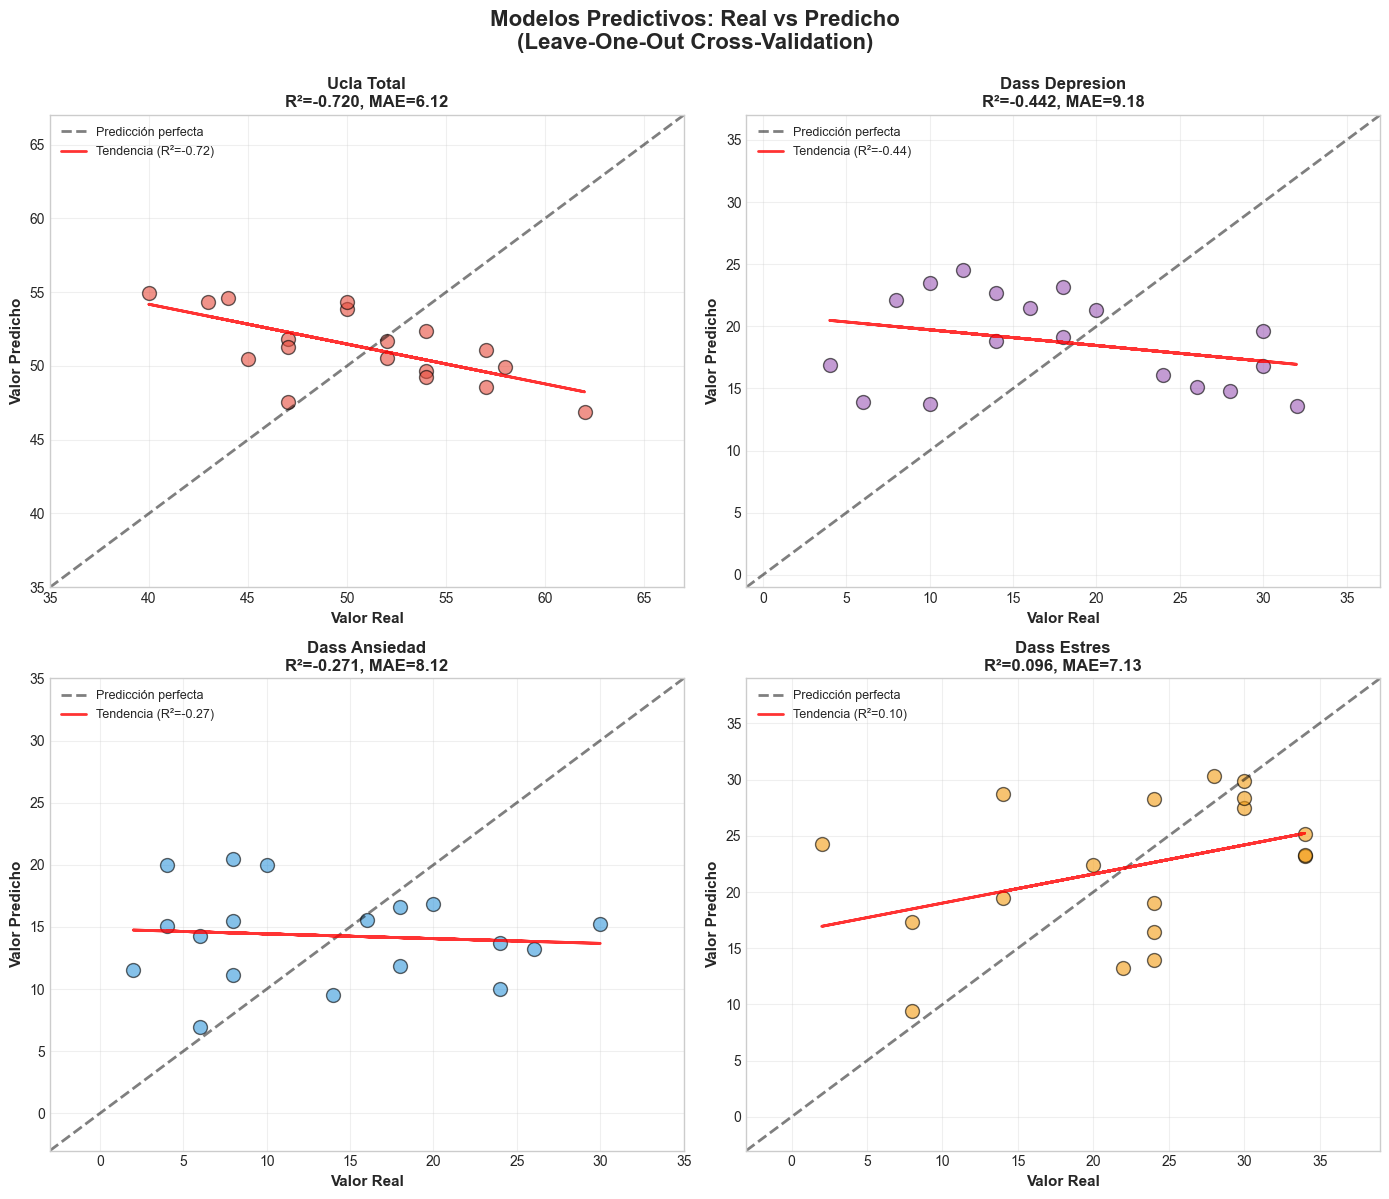

✓ Gráfico guardado: ../data/results/modelos_real_vs_predicho.pdf


In [41]:
# Crear figura con 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

# Colores por modelo
colores = ['#e74c3c', '#9b59b6', '#3498db', '#f39c12']

for idx, (target, resultado) in enumerate(resultados.items()):
    ax = axes[idx]
    
    y_real = resultado['y_real']
    y_pred = resultado['y_pred']
    r2 = resultado['r2']
    mae = resultado['mae']
    
    # Scatter plot
    ax.scatter(y_real, y_pred, alpha=0.6, s=100, color=colores[idx], edgecolor='black')
    
    # Línea identidad (perfect fit)
    lims = [
        min(y_real.min(), y_pred.min()) - 5,
        max(y_real.max(), y_pred.max()) + 5
    ]
    ax.plot(lims, lims, 'k--', alpha=0.5, linewidth=2, label='Predicción perfecta')
    
    # Línea de tendencia
    z = np.polyfit(y_real, y_pred, 1)
    p = np.poly1d(z)
    ax.plot(y_real, p(y_real), "r-", alpha=0.8, linewidth=2, label=f'Tendencia (R²={r2:.2f})')
    
    # Etiquetas
    ax.set_xlabel('Valor Real', fontsize=11, fontweight='bold')
    ax.set_ylabel('Valor Predicho', fontsize=11, fontweight='bold')
    ax.set_title(
        f'{target.replace("_", " ").title()}\nR²={r2:.3f}, MAE={mae:.2f}',
        fontsize=12,
        fontweight='bold'
    )
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

plt.suptitle(
    'Modelos Predictivos: Real vs Predicho\n(Leave-One-Out Cross-Validation)',
    fontsize=16,
    fontweight='bold',
    y=0.995
)
plt.tight_layout()
plt.savefig(output_path / 'modelos_real_vs_predicho.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico guardado: {output_path / 'modelos_real_vs_predicho.pdf'}")

## 6. Feature Importance Comparativo

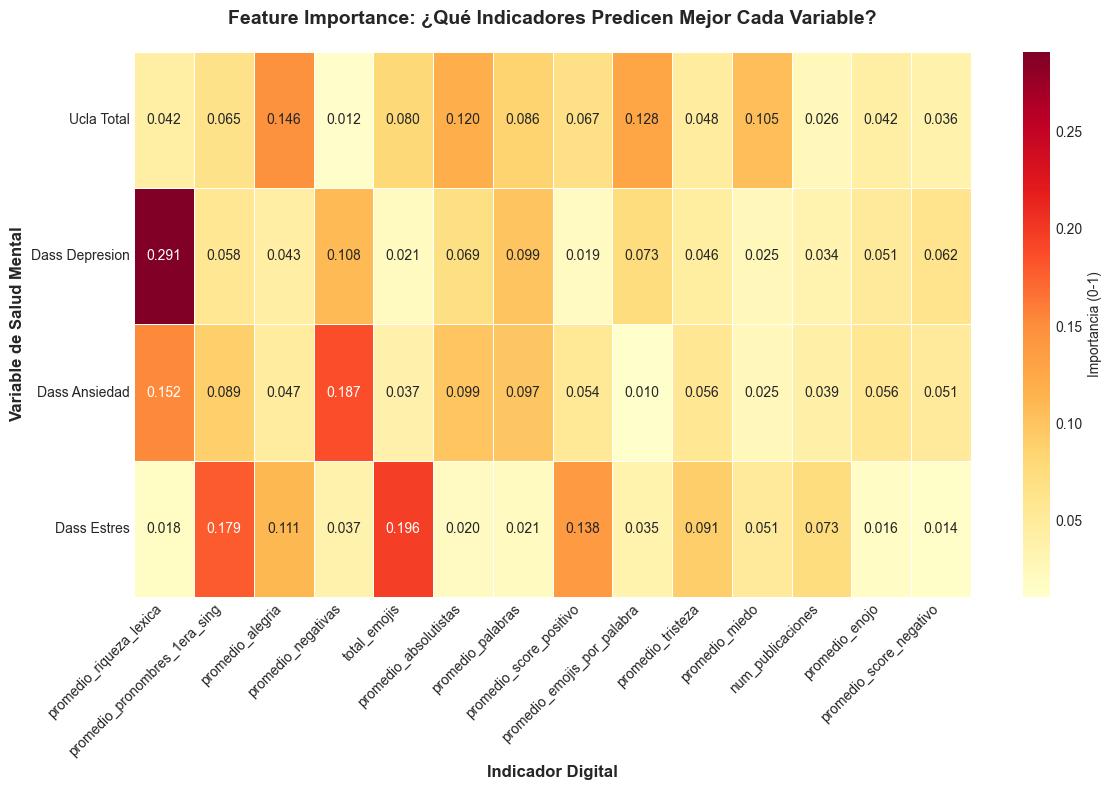

✓ Heatmap guardado: ../data/results/feature_importance_heatmap.pdf


In [42]:
# Crear heatmap de feature importance para todos los modelos
fig, ax = plt.subplots(figsize=(12, 8))

# Recopilar importances de todos los modelos
importance_matrix = []
feature_names = None

for target in targets_disponibles:
    importances = resultados[target]['importances'].set_index('feature')['importance']
    importance_matrix.append(importances)
    if feature_names is None:
        feature_names = importances.index.tolist()

# Crear DataFrame
df_importance = pd.DataFrame(
    importance_matrix,
    index=[t.replace('_', ' ').title() for t in targets_disponibles],
    columns=feature_names
)

# Ordenar por importancia promedio
importancia_promedio = df_importance.mean(axis=0).sort_values(ascending=False)
df_importance = df_importance[importancia_promedio.index]

# Heatmap
sns.heatmap(
    df_importance,
    annot=True,
    fmt='.3f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Importancia (0-1)'},
    linewidths=0.5,
    ax=ax
)

ax.set_xlabel('Indicador Digital', fontsize=12, fontweight='bold')
ax.set_ylabel('Variable de Salud Mental', fontsize=12, fontweight='bold')
ax.set_title(
    'Feature Importance: ¿Qué Indicadores Predicen Mejor Cada Variable?',
    fontsize=14,
    fontweight='bold',
    pad=20
)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(output_path / 'feature_importance_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Heatmap guardado: {output_path / 'feature_importance_heatmap.pdf'}")

## 7. Top Features por Variable

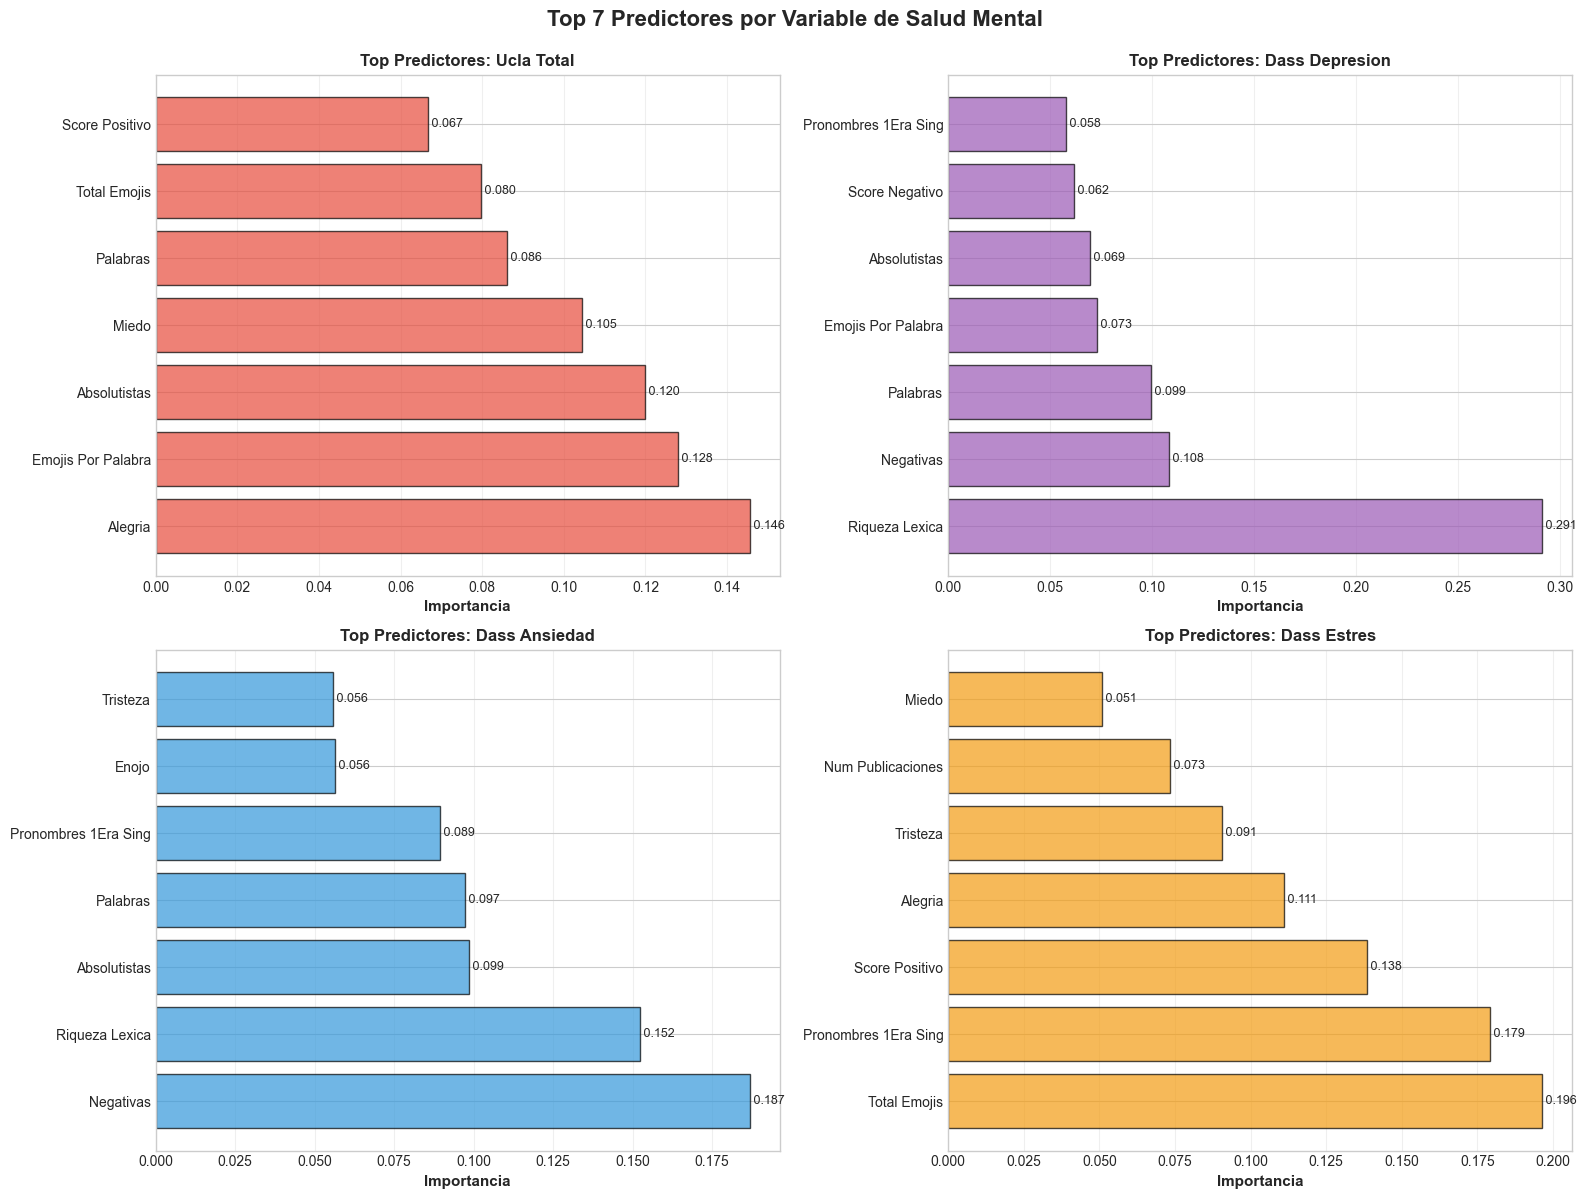

✓ Gráfico guardado: ../data/results/top_predictores.pdf


In [43]:
# Gráfico de barras con top 5 features por cada modelo
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

colores_bar = ['#e74c3c', '#9b59b6', '#3498db', '#f39c12']

for idx, (target, resultado) in enumerate(resultados.items()):
    ax = axes[idx]
    
    # Top 7 features
    top_features = resultado['importances'].head(7)
    
    # Plot horizontal bars
    y_pos = np.arange(len(top_features))
    ax.barh(
        y_pos,
        top_features['importance'],
        color=colores_bar[idx],
        alpha=0.7,
        edgecolor='black'
    )
    
    # Etiquetas cortas
    labels_cortos = [
        f.replace('promedio_', '').replace('_', ' ').title()
        for f in top_features['feature']
    ]
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels_cortos, fontsize=10)
    ax.set_xlabel('Importancia', fontsize=11, fontweight='bold')
    ax.set_title(
        f'Top Predictores: {target.replace("_", " ").title()}',
        fontsize=12,
        fontweight='bold'
    )
    ax.grid(axis='x', alpha=0.3)
    
    # Añadir valores
    for i, (bar, val) in enumerate(zip(ax.patches, top_features['importance'])):
        ax.text(
            val,
            bar.get_y() + bar.get_height()/2,
            f' {val:.3f}',
            va='center',
            fontsize=9
        )

plt.suptitle(
    'Top 7 Predictores por Variable de Salud Mental',
    fontsize=16,
    fontweight='bold',
    y=0.995
)
plt.tight_layout()
plt.savefig(output_path / 'top_predictores.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico guardado: {output_path / 'top_predictores.pdf'}")

## 8. Residuales: Análisis de Errores

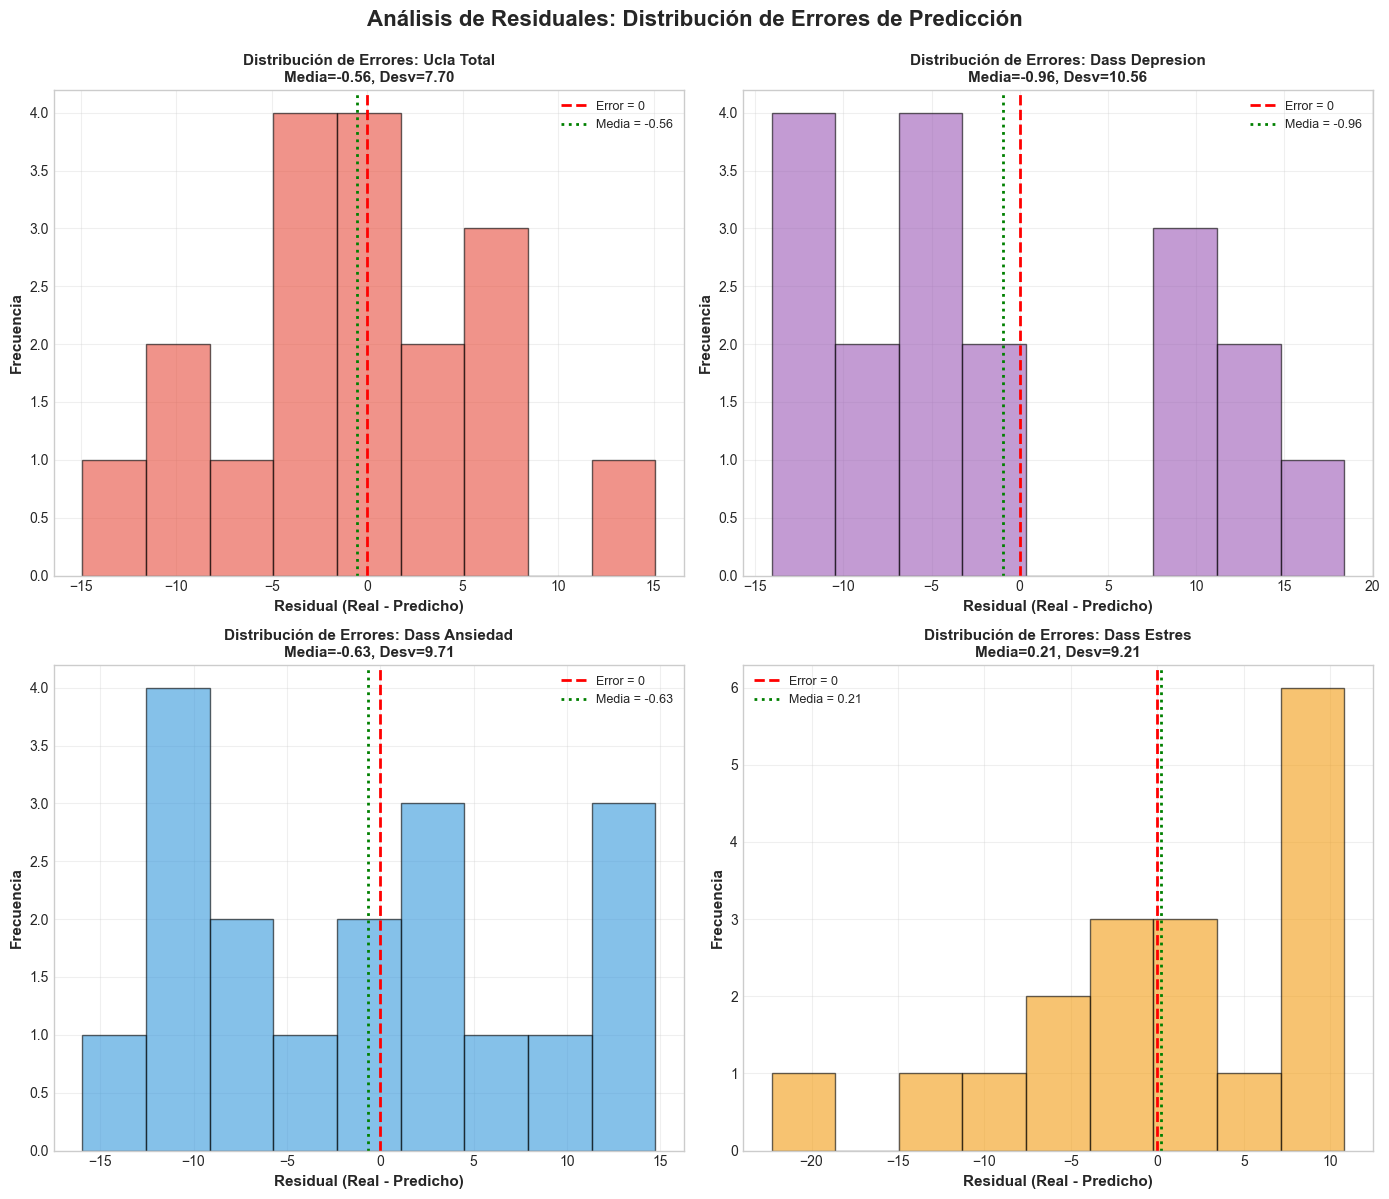

✓ Gráfico guardado: ../data/results/residuales.pdf


In [44]:
# Análisis de residuales (errores de predicción)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (target, resultado) in enumerate(resultados.items()):
    ax = axes[idx]
    
    y_real = resultado['y_real']
    y_pred = resultado['y_pred']
    
    # Calcular residuales
    residuales = y_real - y_pred
    
    # Histogram + KDE
    ax.hist(residuales, bins=min(10, len(residuales)//2), alpha=0.6, color=colores[idx], edgecolor='black')
    
    # Línea en cero
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Error = 0')
    
    # Estadísticas
    media_residual = residuales.mean()
    std_residual = residuales.std()
    
    ax.axvline(media_residual, color='green', linestyle=':', linewidth=2, label=f'Media = {media_residual:.2f}')
    
    # Etiquetas
    ax.set_xlabel('Residual (Real - Predicho)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
    ax.set_title(
        f'Distribución de Errores: {target.replace("_", " ").title()}\nMedia={media_residual:.2f}, Desv={std_residual:.2f}',
        fontsize=11,
        fontweight='bold'
    )
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle(
    'Análisis de Residuales: Distribución de Errores de Predicción',
    fontsize=16,
    fontweight='bold',
    y=0.995
)
plt.tight_layout()
plt.savefig(output_path / 'residuales.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico guardado: {output_path / 'residuales.pdf'}")

## 9. Tabla Resumen de Métricas

In [45]:
# Crear tabla resumen con todas las métricas
metricas_resumen = []

for target, resultado in resultados.items():
    metricas_resumen.append({
        'Variable': target.replace('_', ' ').title(),
        'R²': resultado['r2'],
        'MAE': resultado['mae'],
        'RMSE': resultado['rmse'],
        'MAPE (%)': resultado['mape'],
        'Top Predictor': resultado['importances'].iloc[0]['feature'],
        'Importancia': resultado['importances'].iloc[0]['importance']
    })

df_metricas = pd.DataFrame(metricas_resumen)

# Guardar CSV
archivo_metricas = output_path / 'metricas_modelos_predictivos.csv'
df_metricas.to_csv(archivo_metricas, index=False, encoding='utf-8-sig')

print("\n" + "="*100)
print("TABLA RESUMEN: MÉTRICAS DE TODOS LOS MODELOS")
print("="*100 + "\n")

# Mostrar tabla formateada
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(df_metricas.round(3))

print(f"\n✓ Tabla guardada: {archivo_metricas}")


TABLA RESUMEN: MÉTRICAS DE TODOS LOS MODELOS



,Variable,R²,MAE,RMSE,MAPE (%),Top Predictor,Importancia
0,Ucla Total,-0.720,6.124,7.507,12.425,promedio_alegria,0.146
1,Dass Depresion,-0.442,9.178,10.311,74.298,promedio_riqueza_lexica,0.291
2,Dass Ansiedad,-0.271,8.121,9.454,110.322,promedio_negativas,0.187
3,Dass Estres,0.096,7.131,8.953,92.791,total_emojis,0.196



✓ Tabla guardada: ../data/results/metricas_modelos_predictivos.csv


## 10. SHAP Values (Interpretabilidad Avanzada) - Opcional

Generando SHAP values para interpretabilidad...



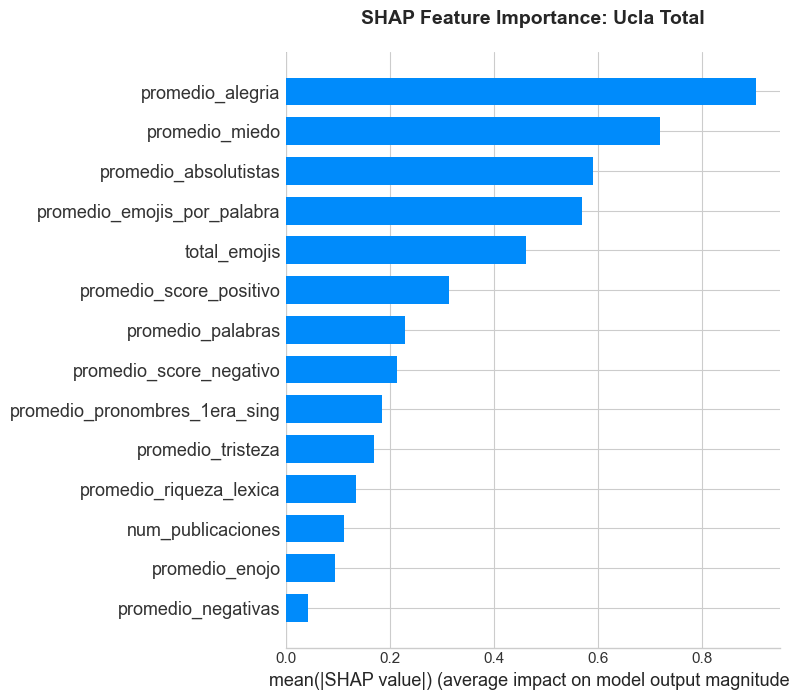

✓ SHAP plot guardado: ../data/results/shap_importance.pdf


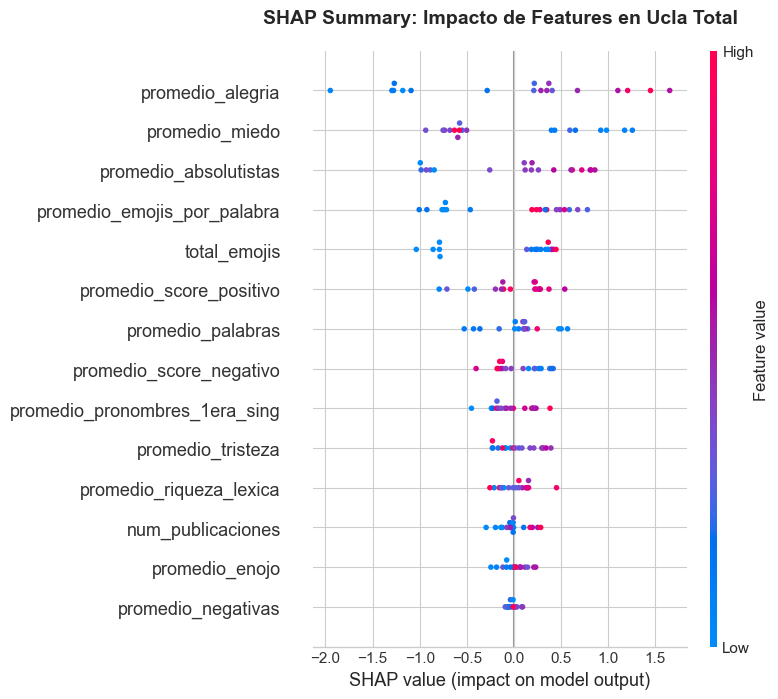

✓ SHAP summary guardado: ../data/results/shap_summary.pdf


In [50]:
if SHAP_AVAILABLE:
    print("Generando SHAP values para interpretabilidad...\n")
    
    # Seleccionar un modelo (ejemplo: UCLA)
    target_ejemplo = 'ucla_total'
    
    if target_ejemplo in resultados:
        resultado = resultados[target_ejemplo]
        modelo = resultado['modelo']
        X_clean = resultado['X_clean']
        
        # Crear explainer
        explainer = shap.TreeExplainer(modelo)
        shap_values = explainer.shap_values(X_clean)
        
        # Summary plot
        fig, ax = plt.subplots(figsize=(12, 8))
        shap.summary_plot(
            shap_values,
            X_clean,
            plot_type="bar",
            show=False
        )
        plt.title(
            f'SHAP Feature Importance: {target_ejemplo.replace("_", " ").title()}',
            fontsize=14,
            fontweight='bold',
            pad=20
        )
        plt.tight_layout()
        plt.savefig(output_path / 'shap_importance.pdf', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✓ SHAP plot guardado: {output_path / 'shap_importance.pdf'}")
        
        # Beeswarm plot (más detallado)
        fig, ax = plt.subplots(figsize=(12, 8))
        shap.summary_plot(
            shap_values,
            X_clean,
            show=False
        )
        plt.title(
            f'SHAP Summary: Impacto de Features en {target_ejemplo.replace("_", " ").title()}',
            fontsize=14,
            fontweight='bold',
            pad=20
        )
        plt.tight_layout()
        plt.savefig(output_path / 'shap_summary.pdf', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✓ SHAP summary guardado: {output_path / 'shap_summary.pdf'}")
    
else:
    print(" SHAP no disponible. Para instalar:")
    print("   pip install shap")
    print("\nSHAP permite:")
    print("   • Interpretar contribución de cada feature a predicciones individuales")
    print("   • Visualizar impacto direccional (positivo/negativo) de features")
    print("   • Identificar interacciones entre features")

## 11. Comparación con Baseline (Modelo Simple)

In [47]:
# Comparar Random Forest vs baseline (predecir siempre la media)
print("\n" + "="*80)
print("COMPARACIÓN: Random Forest vs Baseline (predecir media)")
print("="*80 + "\n")

comparaciones = []

for target, resultado in resultados.items():
    y_real = resultado['y_real']
    y_pred = resultado['y_pred']
    
    # Baseline: predecir siempre la media
    y_baseline = np.full_like(y_real, y_real.mean())
    
    # Métricas baseline
    mae_baseline = mean_absolute_error(y_real, y_baseline)
    rmse_baseline = np.sqrt(mean_squared_error(y_real, y_baseline))
    r2_baseline = r2_score(y_real, y_baseline)  # Siempre será 0
    
    # Métricas Random Forest
    mae_rf = resultado['mae']
    rmse_rf = resultado['rmse']
    r2_rf = resultado['r2']
    
    # Mejora porcentual
    mejora_mae = ((mae_baseline - mae_rf) / mae_baseline) * 100
    mejora_rmse = ((rmse_baseline - rmse_rf) / rmse_baseline) * 100
    
    comparaciones.append({
        'Variable': target.replace('_', ' ').title(),
        'MAE Baseline': mae_baseline,
        'MAE RF': mae_rf,
        'Mejora MAE (%)': mejora_mae,
        'RMSE Baseline': rmse_baseline,
        'RMSE RF': rmse_rf,
        'Mejora RMSE (%)': mejora_rmse,
        'R² RF': r2_rf
    })
    
    print(f" {target.replace('_', ' ').upper()}:")
    print(f"   Baseline MAE: {mae_baseline:.2f} → RF MAE: {mae_rf:.2f} (mejora {mejora_mae:.1f}%)")
    print(f"   Baseline RMSE: {rmse_baseline:.2f} → RF RMSE: {rmse_rf:.2f} (mejora {mejora_rmse:.1f}%)")
    print(f"   R² del modelo: {r2_rf:.3f}\n")

df_comparacion = pd.DataFrame(comparaciones)

# Guardar
archivo_comparacion = output_path / 'comparacion_baseline.csv'
df_comparacion.to_csv(archivo_comparacion, index=False, encoding='utf-8-sig')

print(f"✓ Comparación guardada: {archivo_comparacion}\n")
display(df_comparacion.round(2))


COMPARACIÓN: Random Forest vs Baseline (predecir media)

 UCLA TOTAL:
   Baseline MAE: 4.83 → RF MAE: 6.12 (mejora -26.7%)
   Baseline RMSE: 5.77 → RF RMSE: 7.51 (mejora -30.1%)
   R² del modelo: -0.720

 DASS DEPRESION:
   Baseline MAE: 7.33 → RF MAE: 9.18 (mejora -25.2%)
   Baseline RMSE: 8.62 → RF RMSE: 10.31 (mejora -19.6%)
   R² del modelo: -0.442

 DASS ANSIEDAD:
   Baseline MAE: 7.44 → RF MAE: 8.12 (mejora -9.1%)
   Baseline RMSE: 8.41 → RF RMSE: 9.45 (mejora -12.4%)
   R² del modelo: -0.271

 DASS ESTRES:
   Baseline MAE: 7.78 → RF MAE: 7.13 (mejora 8.3%)
   Baseline RMSE: 9.43 → RF RMSE: 8.95 (mejora 5.0%)
   R² del modelo: 0.096

✓ Comparación guardada: ../data/results/comparacion_baseline.csv



,Variable,MAE Baseline,MAE RF,Mejora MAE (%),RMSE Baseline,RMSE RF,Mejora RMSE (%),R² RF
0,Ucla Total,4.83,6.12,-26.71,5.77,7.51,-30.13,-0.72
1,Dass Depresion,7.33,9.18,-25.16,8.62,10.31,-19.60,-0.44
2,Dass Ansiedad,7.44,8.12,-9.09,8.41,9.45,-12.38,-0.27
3,Dass Estres,7.78,7.13,8.31,9.43,8.95,5.04,0.10


## 12. Reporte Final y Recomendaciones

In [48]:
print("\n" + "="*100)
print("REPORTE FINAL: MODELOS PREDICTIVOS")
print("="*100 + "\n")

print(f"📁 ARCHIVOS GENERADOS:")
print(f"   1. Gráficos Real vs Predicho: {output_path / 'modelos_real_vs_predicho.png'}")
print(f"   2. Heatmap Feature Importance: {output_path / 'feature_importance_heatmap.png'}")
print(f"   3. Top Predictores: {output_path / 'top_predictores.png'}")
print(f"   4. Análisis de Residuales: {output_path / 'residuales.png'}")
print(f"   5. Tabla de Métricas: {output_path / 'metricas_modelos_predictivos.csv'}")
print(f"   6. Comparación Baseline: {output_path / 'comparacion_baseline.csv'}")
if SHAP_AVAILABLE:
    print(f"   7. SHAP Importance: {output_path / 'shap_importance.png'}")
    print(f"   8. SHAP Summary: {output_path / 'shap_summary.png'}")

print(f"\n📊 RESUMEN DE RENDIMIENTO:")
for target, resultado in resultados.items():
    print(f"\n   {target.replace('_', ' ').upper()}:")
    print(f"      • R² = {resultado['r2']:.3f} (explica {resultado['r2']*100:.1f}% de varianza)")
    print(f"      • MAE = {resultado['mae']:.2f}")
    print(f"      • Top predictor: {resultado['importances'].iloc[0]['feature']} ({resultado['importances'].iloc[0]['importance']:.3f})")

print(f"\n🎯 INTERPRETACIÓN:")
print(f"""
1. CAPACIDAD PREDICTIVA:
   • R² > 0.5: Modelo explica >50% de varianza (BUENO para ciencias sociales)
   • R² 0.3-0.5: Modelo moderadamente predictivo (ACEPTABLE con n pequeño)
   • R² < 0.3: Capacidad predictiva limitada (explorar otros indicadores)

2. FEATURE IMPORTANCE:
   • Identifica qué indicadores digitales son más predictivos
   • Prioriza estos indicadores en discusión de tesis
   • Valida teóricamente por qué son importantes

3. MEJORA VS BASELINE:
   • Si mejora >20% → modelo añade valor real
   • Si mejora <10% → considerar si vale la pena vs modelo simple

4. RESIDUALES:
   • Distribución centrada en 0 → modelo no sesgado
   • Outliers → revisar casos específicos manualmente
""")

print(f"\n💡 RECOMENDACIONES PARA LA TESIS:")
print(f"""
1. CON n=11 (ACTUAL):
   ✓ Reportar resultados como EXPLORATORIOS
   ✓ Enfatizar Leave-One-Out CV (validación rigurosa)
   ✓ Discutir feature importance (robusto incluso con n pequeño)
   ⚠️ No sobre-interpretar R² exacto (puede variar con más datos)

2. CON n=20 (OBJETIVO):
   ✓ Re-ejecutar este notebook con datos completos
   ✓ R² será más estable y confiable
   ✓ Considerar train/test split (80/20) además de LOO-CV
   ✓ Comparar resultados n=11 vs n=20 en discusión

3. PARA LA DEFENSA:
   • Gráfico Real vs Predicho: muestra ajuste visual del modelo
   • Feature Importance: responde "¿qué indicadores importan más?"
   • Comparación Baseline: demuestra que modelo añade valor
   • Cita R² como "capacidad predictiva" (no "causalidad")

4. EN EL DOCUMENTO:
   • Sección Metodología: describir Random Forest + LOO-CV
   • Sección Resultados: tabla de métricas + gráficos
   • Sección Discusión: interpretar qué indicadores predicen mejor y POR QUÉ
   • Limitaciones: mencionar n pequeño, necesidad de validación externa

5. ANÁLISIS COMPLEMENTARIOS:
   • Combinar con correlaciones (notebook 6): triangular hallazgos
   • Vincular con clustering (notebook 9): ¿diferentes perfiles tienen diferentes predictores?
   • Revisar perfiles individuales (notebook 10): casos donde modelo falla/acierta
""")

print("\n" + "="*100)
print("✅ ANÁLISIS PREDICTIVO COMPLETADO")
print("="*100 + "\n")

print("🎯 SIGUIENTE PASO: Revisar gráficos generados y analizar cualitativamente casos\n")
print("    donde el modelo predice bien/mal para enriquecer discusión.\n")


REPORTE FINAL: MODELOS PREDICTIVOS

📁 ARCHIVOS GENERADOS:
   1. Gráficos Real vs Predicho: ../data/results/modelos_real_vs_predicho.png
   2. Heatmap Feature Importance: ../data/results/feature_importance_heatmap.png
   3. Top Predictores: ../data/results/top_predictores.png
   4. Análisis de Residuales: ../data/results/residuales.png
   5. Tabla de Métricas: ../data/results/metricas_modelos_predictivos.csv
   6. Comparación Baseline: ../data/results/comparacion_baseline.csv
   7. SHAP Importance: ../data/results/shap_importance.png
   8. SHAP Summary: ../data/results/shap_summary.png

📊 RESUMEN DE RENDIMIENTO:

   UCLA TOTAL:
      • R² = -0.720 (explica -72.0% de varianza)
      • MAE = 6.12
      • Top predictor: promedio_alegria (0.146)

   DASS DEPRESION:
      • R² = -0.442 (explica -44.2% de varianza)
      • MAE = 9.18
      • Top predictor: promedio_riqueza_lexica (0.291)

   DASS ANSIEDAD:
      • R² = -0.271 (explica -27.1% de varianza)
      • MAE = 8.12
      • Top predic